### Data Visualization - Ideal vs Encountered

In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py


#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#math
import numpy as np
import math
import scipy.fftpack
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate
pd.TimeSeries = pd.Series 

#gps
from geopy import distance
import geopandas as gpd
import utm
import datetime as dt

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from IPython.display import HTML


#### Load Data

In [2]:
set_number = 5

dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'
windbag = 'wind0'+str(set_number)+'Run03.hdf'
westeast_load = 'ewdata0'+str(set_number)+'Run03.hdf'
northsouth_load= 'nsdata0'+str(set_number)+'Run03.hdf'
odor_load = 'Interpolated_'+str(set_number)+'.h5'
puffsize = pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/puff_size.hdf')

In [3]:
#windbag
wind=pd.read_hdf(dir+windbag)
we=pd.read_hdf(dir+westeast_load)
ns=pd.read_hdf(dir+northsouth_load)

In [4]:
#odorbag
odor= pd.read_hdf(dir+odor_load)
time= odor.master_time-odor.master_time[0]
odor.insert(1,'sync_time',time) 

### Creating Dataframe for Puff Size

In [6]:
## creating puff dataframe
## going to copy to a new frame to keep this container separate as the for loop takes significant time to execute

# puff = pd.DataFrame(index=range(2987),columns=range(2987))
# puffsize=pd.DataFrame()

# for i in range(0, len(puff.columns)):
#     puff[i]=puff.index

# puff.columns = ['particle' + str(col) for col in puff.columns] #renaming for looping ease
# puffsize[0] = puff.iloc[:,0] #copying the first columns of data

# #shifting every column by the column-th number
# for i in range(1, len(puff.columns)):
#     puffsize[i]=puff['particle' + str(i)].shift(periods=i)

# puffsize=puffsize.fillna(0) #replacing NaN with zeroes
# puffsize.columns = ['particle' + str(col) for col in puffsize.columns] #renaming columns names optional
# puffsize= puffsize.astype(int)
# puffsize.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/puff_size.hdf', key='puffsize', mode='w')

### Converting lat lon information to meters

In [5]:
from shapely.geometry import Point
odor['geometry'] = odor.apply(lambda row: Point(row.lon, row.lat), axis=1)

geodf = gpd.GeoDataFrame(odor)
geodf.crs= {'init': 'epsg:4326'}
# change the projection of geodf
geodf = geodf.to_crs("+proj=utm +zone=11 +ellps=WGS84 +datum=WGS84 +units=m +no_def")

geodf["x"] = geodf.geometry.apply(lambda row:row.x)
geodf["y"] = geodf.geometry.apply(lambda row:row.y)

In [6]:
#source location to meters
source = (40.79376709443614, -119.15757512132207)
u =  utm.from_latlon(40.79376709443614, -119.15757512132207)

In [7]:
#adding sync_time from zero, optional

newtime= wind.sync_time-wind.sync_time.iloc[0]
wind.insert(1,'ntime',newtime) 

newtime=newtime.reset_index()
# newtime = newtime.drop(columns=['index'])

we.insert(0,'sync_time',newtime.sync_time)
ns.insert(0,'sync_time',newtime.sync_time)

In [8]:
xfromsrc= geodf.x-u[0]
geodf.insert(10,'xsrc',xfromsrc) 

yfromsrc = geodf.y-u[1]
geodf.insert(11,'ysrc', yfromsrc)

#### Selecting a smaller slot of data

In [49]:
query = 'sync_time >= 100  and sync_time <=150'
dfo = odor.query(query)
dfwe = we.query(query)
dfns = ns.query(query)
dfwe = dfwe.reset_index()
dfns = dfns.reset_index()

In [50]:
# query = 'odor >= 7'
# df_t=geodf.query(query)
# df_t=df_t.reset_index()

In [51]:
query_ = 'sync_time >=100  and sync_time <=150'
geodfsub = geodf.query(query_)
geodfsub = geodfsub.reset_index()

In [15]:
# # # drop additional time stamps if necessary
# dfns = dfns.drop(columns=[ 'index1', 'sync_time'])
# dfwe = dfwe.drop(columns=['index', 'sync_time'])
# geodfsub = geodfsub.drop(columns = ['index', 'size'])

In [21]:
dfns

,index1,sync_time,particle0,particle1,particle2,particle3,particle4,particle5,particle6,particle7,...,particle2977,particle2978,particle2979,particle2980,particle2981,particle2982,particle2983,particle2984,particle2985,particle2986
0,1001,100.099733,166.135651,166.051148,165.969646,165.891644,165.809142,165.722139,165.633137,165.550135,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1002,100.199735,166.314156,166.229653,166.148151,166.070149,165.987647,165.900644,165.811642,165.728640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1003,100.299738,166.503161,166.418659,166.337156,166.259154,166.176652,166.089649,166.000647,165.917645,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1004,100.399741,166.691666,166.607163,166.525661,166.447659,166.365157,166.278154,166.189152,166.106150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1005,100.499743,166.870171,166.785668,166.704166,166.626164,166.543662,166.456659,166.367657,166.284655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,2295,229.500265,386.930863,386.846361,386.764858,386.686856,386.604354,386.517352,386.428349,386.345347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1295,2296,229.600268,387.033366,386.948863,386.867361,386.789359,386.706857,386.619854,386.530852,386.447850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1296,2297,229.700270,387.136369,387.051866,386.970364,386.892362,386.809860,386.722857,386.633855,386.550853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1297,2298,229.800273,387.239371,387.154869,387.073367,386.995365,386.912862,386.825860,386.736858,386.653856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#ns = ns.reset_index()
# we = we.drop(columns=['sync_time'])
dfns = dfns.drop(columns=['index1'])
dfwe = dfwe.drop(columns=['index'])
geodfsub = geodfsub.drop(columns = ['index'])

In [26]:
we

,sync_time,particle0,particle1,particle2,particle3,particle4,particle5,particle6,particle7,particle8,...,particle2977,particle2978,particle2979,particle2980,particle2981,particle2982,particle2983,particle2984,particle2985,particle2986
0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.100003,0.046001,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.200006,0.077502,0.031501,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.300008,0.119503,0.073502,0.042001,0.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.400011,0.163005,0.117003,0.085502,0.043501,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2982,298.200140,-222.773296,-222.819297,-222.850798,-222.892799,-222.936301,-222.977802,-223.022803,-223.068304,-223.123306,...,-0.692519,-0.560015,-0.420011,-0.282007,-0.143004,0.000000,NaN,NaN,NaN,NaN
2983,298.300143,-222.919300,-222.965301,-222.996802,-223.038803,-223.082305,-223.123806,-223.168807,-223.214308,-223.269310,...,-0.838523,-0.706019,-0.566015,-0.428011,-0.289008,-0.146004,0.000000,NaN,NaN,NaN
2984,298.400146,-223.057304,-223.103305,-223.134806,-223.176807,-223.220308,-223.261810,-223.306811,-223.352312,-223.407313,...,-0.976527,-0.844023,-0.704019,-0.566015,-0.427011,-0.284008,-0.138004,0.000000,NaN,NaN
2985,298.500149,-223.188808,-223.234809,-223.266310,-223.308311,-223.351812,-223.393313,-223.438314,-223.483816,-223.538817,...,-1.108030,-0.975527,-0.835523,-0.697519,-0.558515,-0.415511,-0.269507,-0.131504,0.000000,NaN


### Interpolate

In [61]:
df_odor_loc=pd.DataFrame({'odor_time': geodf.master_time,'xsrc': geodf.xsrc, 'ysrc':geodf.ysrc,})
df_wind_loc=pd.DataFrame({'wind_time': wind.time_epoch,'U': wind.U,'V': wind.V,})

In [62]:
df_new = pd.concat([df_odor_loc,df_wind_loc], sort=True)
combined_time = np.hstack([df_odor_loc.odor_time, df_wind_loc.wind_time])

In [63]:
df_new['time'] = combined_time
df_new=df_new.sort_values(by=['time'])

In [65]:
dt_odor = np.median(np.diff(df_new.odor_time.dropna().values))
print('dt Odor: ', dt_odor)
dt_wind = np.median(np.diff(df_new.wind_time.dropna().values))
print('dt Wind: ', dt_wind)

dt Odor:  0.004995822906494141
dt Wind:  0.10000276565551758


In [66]:
first_time = np.max([df_new.odor_time.min(), df_new.wind_time.min()])
last_time = np.min([df_new.odor_time.max(), df_new.wind_time.max()])
master_time = np.arange(first_time, last_time, dt_odor)

In [69]:
# create interpolation function and inteprolate sensor 1
df_odor_1= df_new[['odor_time', 'xsrc']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_1.odor_time, df_odor_1.xsrc)
interp_odor_x = func_interp_sensor_1(master_time)

df_odor_2= df_new[['odor_time', 'ysrc']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_odor_2.odor_time, df_odor_2.ysrc)
interp_odor_y = func_interp_sensor_1(master_time)

df_wind_1= df_new[['wind_time', 'U']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_1.wind_time, df_wind_1.U)
interp_wind_U = func_interp_sensor_1(master_time)

df_wind_2= df_new[['wind_time', 'V']].dropna()
func_interp_sensor_1 = scipy.interpolate.interp1d(df_wind_2.wind_time, df_wind_2.V)
interp_wind_V = func_interp_sensor_1(master_time)

In [74]:
windn = pd.DataFrame({'master_time': master_time,
                           'xsrc': interp_odor_x,
                           'ysrc': interp_odor_y,
                           'U': interp_wind_U,
                           'V': interp_wind_V,})

In [75]:
windn.to_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_Interpolated.hdf', key='df2', mode='w')

In [14]:
windn=pd.read_hdf('~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_Interpolated.hdf')
windn_sync_time=windn.master_time-windn.master_time[0]
windn.insert(1,'sync_time',windn_sync_time)

In [34]:
#select a sub data
windnsub=windn.query(query)

In [35]:
posu=[]
posv=[]
for i in range(len(windnsub.master_time)):
    posu.append(integrate.cumtrapz(windnsub.U[i:],windnsub.master_time[i:], axis=0, initial = 0.0)) 
    posv.append(integrate.cumtrapz(windnsub.V[i:],windnsub.master_time[i:], axis=0, initial = 0.0))

In [37]:
#creating dataframes for each westeast particle and northsouth
westeast=pd.DataFrame(posu,columns=['particle{}'.format(x+1) for x in range(len(posu))]) #particle U
northsouth=pd.DataFrame(posv,columns=['particle{}'.format(x+1) for x in range(len(posv))]) #particle in V

In [38]:
dfi = pd.DataFrame()
dfi['index']=westeast.index
westeast=westeast.T
westeast.set_index(dfi.index, inplace=True)
westeast.columns = ['particle' + str(col) for col in westeast.columns]
delta=pd.DataFrame()
delta[0] = westeast.iloc[:,0]
for i in range(1,len(westeast.columns)):
    delta[i]=westeast['particle' + str(i)].shift(periods=i)

delta.columns = ['particle' + str(col) for col in delta.columns]
delta=delta.fillna(0)

In [44]:
#converting rows to columns for position northsouth
dfi['index1']=northsouth.index
northsouth=northsouth.T
northsouth.set_index(dfi.index1, inplace=True)
northsouth.columns = ['particle' + str(col) for col in northsouth.columns]
gamma=pd.DataFrame()
gamma[0] = northsouth.iloc[:,0]
for i in range(1,len(westeast.columns)):
    gamma[i]=northsouth['particle' + str(i)].shift(periods=i)
    
gamma.columns = ['particle' + str(col) for col in gamma.columns]
gamma=gamma.fillna(0)


In [60]:
windnsub = windnsub.reset_index()
windnsub = windnsub.drop(columns=['index'])
windnsub

,master_time,sync_time,xsrc,ysrc,U,V
0,1.603226e+09,100.001387,0.302476,2.446087,-0.872652,1.788509
1,1.603226e+09,100.006383,0.302197,2.443319,-0.880645,1.784012
2,1.603226e+09,100.011379,0.301918,2.440551,-0.888638,1.779516
3,1.603226e+09,100.016375,0.301639,2.437783,-0.896631,1.775020
4,1.603226e+09,100.021370,0.301360,2.435015,-0.904624,1.770524
...,...,...,...,...,...,...
10004,1.603226e+09,149.979599,-4.982910,5.533575,-0.764594,2.237456
10005,1.603226e+09,149.984595,-4.987452,5.528970,-0.758599,2.242951
10006,1.603226e+09,149.989591,-4.991994,5.524364,-0.752604,2.248446
10007,1.603226e+09,149.994587,-4.996536,5.519759,-0.746609,2.253941


In [100]:
odor_presence=[]
count=0
for i in range(len(geodfsub.xsrc)):
    k=0

    windx=delta.loc[i]
    windy=gamma.loc[i]
    
    point1 = np.array((geodfsub.xsrc[i],geodfsub.ysrc[i]))
    for j in range(len(windx)):
        point2 = np.array((windx[j],windy[j]))
        distance = np.linalg.norm(point1-point2)
        count+=1
        if(distance<=2):
            k+=1
            break
        else:
            k+=0
     
    if(k>0):
        odor_presence.append(1)
    else:
        odor_presence.append(0)

In [101]:
count

48133134

In [114]:
odor_expected = []
for i in range(len(geodfsub.odor)):
    if(odor_presence[i]==1):
        odor_expected.append(geodfsub.odor[i])
    else:
        odor_expected.append(0.6)

In [115]:
geodfsub['odor_expected']=odor_expected

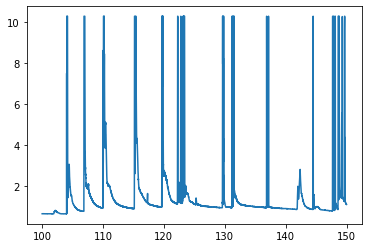

In [116]:
plt.plot(geodfsub.sync_time,geodfsub.odor)

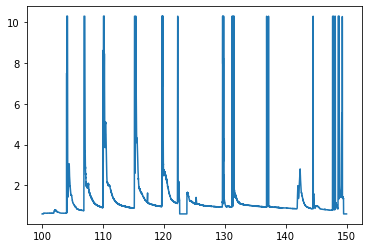

In [118]:
plt.plot(geodfsub.sync_time,geodfsub.odor_expected)

#### Animation method using multiple plots (extremely slow)

In [ ]:
plt.plot(geodfsub.)

In [15]:
dir = '../../../Research/Images/container_odor/'
N = 0
for i in range(len(geodf.xsrc)):
    fig = plt.figure()
    fig.suptitle('Odor Encounters')
    ax = plt.axes (xlim=(-8,15), ylim=(-2,30))
    ax.set_xlabel('Longitude (meters)')
    ax.set_ylabel('Latitude(meters)')
    if (i<=3000):
        ax.scatter(geodf.xsrc[:i],geodf.ysrc[:i], c=geodf.odor[:i], cmap='magma', s=15)
    else:
        ax.scatter(geodf.xsrc[N:i],geodf.ysrc[N:i], c=geodf.odor[N:i], cmap='magma', s=15)
        N=N+1
        
    fig.savefig(dir + "plot" + str(i) + ".jpg")
    plt.close()

In [166]:
dir = '../../../Research/Images/container_wind/'
for i in range(len(we)):
    fig = plt.figure()
    fig.suptitle('Odor Encounters')
    ax = plt.axes (xlim=(-8,15), ylim=(-2,30))
    ax.set_xlabel('Longitude (meters)')
    ax.set_ylabel('Latitude(meters)')
    ax.scatter(we.loc[i], ns.loc[i],c ='b', cmap='magma', s=puffsize.loc[i]* 0.1)
    plt.plot(0,0, marker='x', markersize=15)
    fig.savefig(dir + "plot" + str(i) + ".jpg")
    plt.close()

In [7]:
fig = plt.figure()
ax = plt.axes(xlim=(-22,2), ylim=(-15,30))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()
line, = ax.scatter([],[], 'o', c =geodfsub.odor lw=2)

def init():
    line.set_data([],[])
    return line,

def get_data_x(i):
    return we.loc[i]

def get_data_y(i):
    return ns.loc[i]

def update(i):
    x = get_data_x(i)
    y = get_data_y(i)
    line.set_data(x,y)
    return line,

an = animation.FuncAnimation(fig,update,frames = pd.Index.intersection(we.index,ns.index),
                              interval = 5, blit=False)
#an.save('../../../Research/Images/Video/fast_flow.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
# plt.show()

#### 2D scatter plot for entire 300 seconds for ideal vs actual odor counters

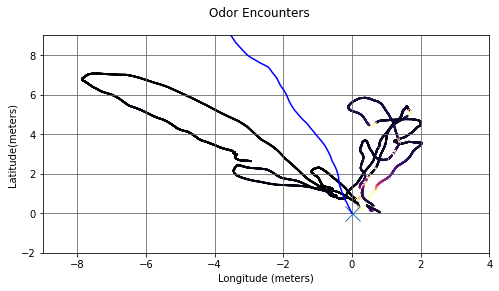

In [57]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor Encounters')
ax = plt.axes (xlim=(-9,4), ylim=(-2,9))
# Plot the data
ax.scatter(geodfsub.xsrc, geodfsub.ysrc, c=geodfsub.odor, cmap='magma', s= 0.8)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, c='b')


#### 2D scatter plot for high odor concentration vs ideal wind particle

(-16.0, 3.0)

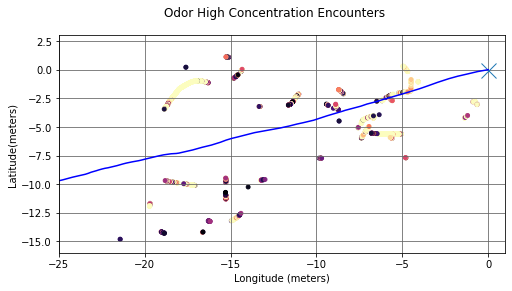

In [13]:
fig, ax = plt.subplots(1, figsize=(8, 4))
fig.suptitle('Odor High Concentration Encounters')
ax = plt.axes (xlim=(-9,4), ylim=(-2,9))
# Plot the data
ax.scatter(df_t.xsrc, df_t.ysrc, c=df_t.odor, cmap='magma', s= 15)
ax.set_xlabel('Longitude (meters)')
ax.set_ylabel('Latitude(meters)')
plt.plot(0,0, marker='x', markersize=15)
# Show the grid lines as dark grey lines
ax.grid(b=True, which='major', color='#666666', linestyle='-')
plt.plot(we.particle0,ns.particle0, markersize=20, c='b')


#### ANIMATION 02 - Ideal vs Encountered Odor

In [ ]:
## Setting figure

fig = plt.figure()
ax = plt.axes(xlim=(-9,4), ylim=(-2,9))
ax.set_xlabel('Eastwest (meters)')
ax.set_ylabel('NorthSouth (meters)')
plt.close()

wind, = ax.plot([],[], 'o', color ="b", lw = 2)
line, = ax.scatter([],[], c = geodfsub.odor, cmap='magma', s= 15)

def init():
    line.set_data([],[])  
    wind.set_data([],[])
    return wind,

def get_data_we_(i):
    return dfwe.loc[i]

def get_data_ns_(i):
    return dfns.loc[i]

def get_data_x_(i):
    return geodfsub.xsrc[i]

def get_data_y_(i):
    return geodfsub.ysrc[i]

def update(i):
#     wex = get_data_we_(i)
#     nsy = get_data_ns_(i)
#     wind.set_data(wex,nsy)
    x = get_data_x_(i)
    y = get_data_y_(i)
    line.set_data(x,y)
    
    return line,




In [19]:
# ani = animation.FuncAnimation(fig, update, init_func=init, frames = int(len(geodfsub.ysrc)/2), interval = 5, blit=False)
ani = animation.FuncAnimation(fig, update, init_func=init, frames = 500, interval = 5, blit=False)


#ani.save('../../../Research/Images/Video/test_ideal.mp4', fps=100, extra_args=['-vcodec', 'libx264'])
#HTML(ani.to_html5_video())




#### Note: Number of rows for wind sensor for a certain time slot is much lesser than number of rows of the data collected (position data) >>>> GPS frequency is much higher